# Water Meter OCR Apiary Project

The aim of this project is to develope an OCR model that is capable of accurately reading water meters. To achieve our goal, we will break the project down into three steps. First, we will develop a model that accurately detects the region of interest for each photo - that is, the region where the meter reading is heald. Next, we will develop a model to segment each digit in a meter. Finally, we will develop a model which can return the digits from each meter.

In [11]:
#Import Relevant Libraries
import re, cv2, os, json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageOps
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import decimal
import shutil

In [12]:
%%writefile skip_kernel_extension.py
def skip(line, cell=None):
    '''Skips execution of the current line/cell if line evaluates to True.'''
    if eval(line):
        return

    get_ipython().ex(cell)

def load_ipython_extension(shell):
    '''Registers the skip magic when the extension loads.'''
    shell.register_magic_function(skip, 'line_cell')

def unload_ipython_extension(shell):
    '''Unregisters the skip magic when the extension unloads.'''
    del shell.magics_manager.magics['cell']['skip']

Writing skip_kernel_extension.py


In [13]:
%load_ext skip_kernel_extension

In [87]:
#Load data and paths
data = pd.read_csv('/kaggle/input/yandextoloka-water-meters-dataset/WaterMeters/data.csv')
images_folder = "/kaggle/input/yandextoloka-water-meters-dataset/WaterMeters/images"
masks_folder = "/kaggle/input/yandextoloka-water-meters-dataset/WaterMeters/masks"
coll_folder = "/kaggle/input/yandextoloka-water-meters-dataset/WaterMeters/collage"

## Exploratory Data Analyis

To start, let us see how many observations we will be working with and examine a few representative images of water meters.

In [15]:
#Obtain a count of images, masks, and observations.
print(f'Total number of images: {len(os.listdir(images_folder))}')
print(f'Total number of image masks: {len(os.listdir(masks_folder))}')
print(f'Length of dataset: {len(data)}')

Total number of images: 1244
Total number of image masks: 1244
Length of dataset: 1244


From the above output, we can see that there are 1244 images in this dataset, which corresponds to the number of masks and observations.

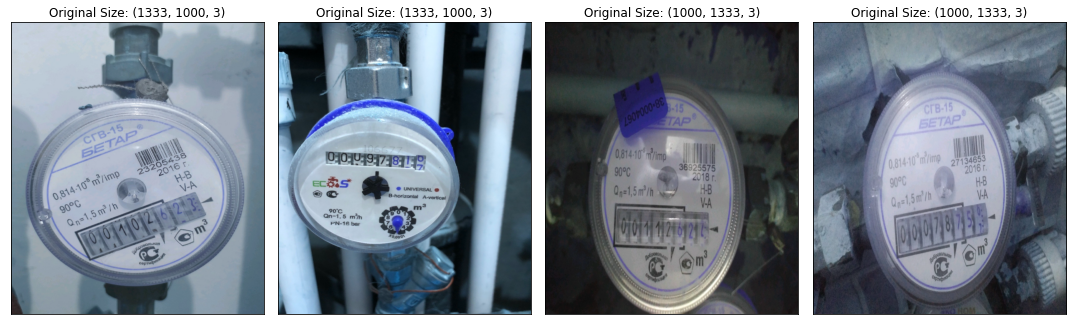

In [16]:
#Create figure and empty list for axes
axes=[]
fig=plt.figure(figsize=(15, 15))

#Show first 4 images in dataset with corresponding shape.
for a in range(4):
    #Obtain file name and create path.
    file = os.listdir("/kaggle/input/yandextoloka-water-meters-dataset/WaterMeters/images/")[a]
    image_path = os.path.join(images_folder, file) 

    #Read the file image and resize it for show.
    img = cv2.imread(image_path)
    resized_image = cv2.resize(img, (1300, 1500), interpolation = cv2.INTER_AREA)
    
    #Print the resized image and dislpay the shape.
    axes.append(fig.add_subplot(1, 4, a+1) )
    subplot_title=(f"Original Size: {img.shape}")
    axes[-1].set_title(subplot_title)  
    plt.imshow(resized_image)

#Remove ticks from each image.
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

#Plot the image.
fig.tight_layout()    
plt.show()

From the above images, we can see that there are different types of water meters contained within the dataset. We can also see that the angles of the photos differ between images. This should not be a problem for our purposes, so long as the annotation was carried out correctly. To see whether this is the case, let us show the corresponding mask images.

Note: Later on in the project, we built a Faster RCNN model in order to predict the digits displayed on a meter. In doing so, we manually labeled the digits in over 200 meters, which allowed us to visualize the different types of meters present. We found that most meters have digit displays, though there are some with 7 digits and few with 5. For the 7 and 8 digit meters, the final three digits represent milliliters; however, milliliters are not present on the 5 digit displays. This is important to keep in mind, as we will need to infer where the decimal is to be placed once we obtain predicted readings from our Faster RCNN model. 

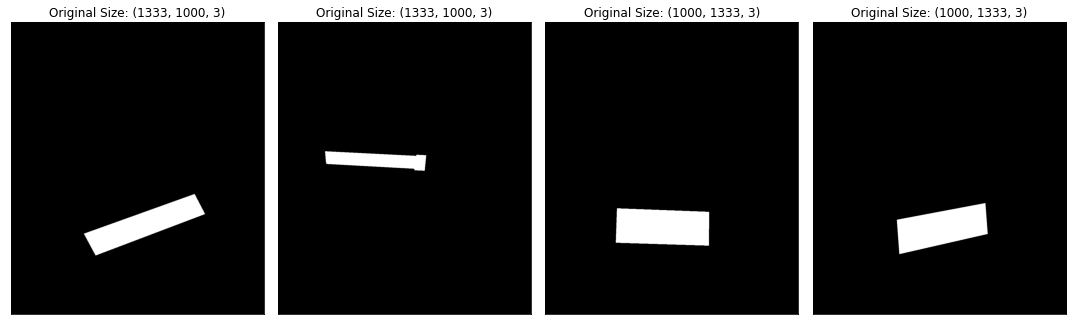

In [17]:
#Create figure and empty list for axes
axes=[]
fig=plt.figure(figsize=(15, 15))

#Show first 4 images in dataset with corresponding shape.
for a in range(4):
    #Obtain file name and create path.
    file = os.listdir("/kaggle/input/yandextoloka-water-meters-dataset/WaterMeters/masks/")[a]
    image_path = os.path.join(masks_folder, file) 
    
    #Read the file image and resize it for show.
    img = cv2.imread(image_path)
    resized_image = cv2.resize(img, (1300, 1500), interpolation = cv2.INTER_AREA)
    
    #Print the resized image and dislpay the shape.
    axes.append(fig.add_subplot(1, 4, a+1) )
    subplot_title=(f"Original Size: {img.shape}")
    axes[-1].set_title(subplot_title)  
    plt.imshow(resized_image)

#Remove ticks from each image.
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

#Plot the image.
fig.tight_layout()    
plt.show()

It appears that the masks accurately convey the region of interest for our meters - that is, they accurately convey the location of the portion of the meter that contains the current reading. This is great news, as we can use these masks to train a UNET model to produce masks of other water meters. Let us now examine the type of informaiton contained in the data provided.

In [18]:
#Examine the head of the 'data' DataFrame
pd.set_option('display.max_colwidth', 70)
display(data.head())

,photo_name,value,location
0,id_53_value_595_825.jpg,595.825,"{'type': 'polygon', 'data': [{'x': 0.30788, 'y': 0.30207}, {'x': 0..."
1,id_553_value_65_475.jpg,65.475,"{'type': 'polygon', 'data': [{'x': 0.26133, 'y': 0.24071}, {'x': 0..."
2,id_407_value_21_86.jpg,21.860,"{'type': 'polygon', 'data': [{'x': 0.27545, 'y': 0.19134}, {'x': 0..."
3,id_252_value_313_322.jpg,313.322,"{'type': 'polygon', 'data': [{'x': 0.21967, 'y': 0.50845}, {'x': 0..."
4,id_851_value_305_162.jpg,305.162,"{'type': 'polygon', 'data': [{'x': 0.06983, 'y': 0.43491}, {'x': 0..."


Note: It appears that our DataFrame contains the image name, ground truth meter reading, and polygonal mask locations for each image. While the 'location' values are stored as strings, they appear to be in JSON format, where each x and y coordinate corresponds with a point on a polygonal mask. These points seem to be represented as percentages, as they appear to be scaled between 0 and 1; this may be useful in case of image rescaling, as the points could always accurately represent coordinates of a ROI when plotted according to the relevant image's scale. We will leave the 'location' column untouched and deal with any sort of rescaling/reformatting we may need when building our segmentation mode. That being said, in case we are required to submit the polygonal coordinates in a different format than what was provided, let us quickly save all the x and y coordinates for each image as different features. 

In [19]:
#Create function to extract polygon locations from 'location' string.
def location_vals(obvs, x_or_y):
    '''
    Function uses regular expressions to parse the "location" string for each observation.
    Inputs are "obvs" and "x_or_y".
    
    obvs: This simply serves as the string being passed into the function.
    x_or_y: If "x" is entered, then the function extracts all "x" location values. If anything else, then it extracts "y" location values.
    '''
    if x_or_y == 'x':
        x = re.findall(r"\'x\': ([0-9.]*),", obvs)
        return x
    else:
        y = re.findall(r"\'y\': ([0-9.]*)}", obvs)
        return y

In [20]:
#Create new column with x and y location values.
data['x_loc_perc'] = data['location'].apply(lambda obvs: location_vals(obvs, 'x'))
data['y_loc_perc'] = data['location'].apply(lambda obvs: location_vals(obvs, 'y'))
display(data.head())

,photo_name,value,location,x_loc_perc,y_loc_perc
0,id_53_value_595_825.jpg,595.825,"{'type': 'polygon', 'data': [{'x': 0.30788, 'y': 0.30207}, {'x': 0...","[0.30788, 0.30676, 0.53501, 0.53445, 0.56529, 0.56697, 0.53501, 0....","[0.30207, 0.32731, 0.33068, 0.33699, 0.33741, 0.29786, 0.29786, 0...."
1,id_553_value_65_475.jpg,65.475,"{'type': 'polygon', 'data': [{'x': 0.26133, 'y': 0.24071}, {'x': 0...","[0.26133, 0.31405, 0.31741, 0.30676, 0.33985, 0.29386]","[0.24071, 0.23473, 0.26688, 0.26763, 0.60851, 0.61449]"
2,id_407_value_21_86.jpg,21.860,"{'type': 'polygon', 'data': [{'x': 0.27545, 'y': 0.19134}, {'x': 0...","[0.27545, 0.37483, 0.38935, 0.28185]","[0.19134, 0.18282, 0.76071, 0.76613]"
3,id_252_value_313_322.jpg,313.322,"{'type': 'polygon', 'data': [{'x': 0.21967, 'y': 0.50845}, {'x': 0...","[0.21967, 0.70811, 0.70008, 0.21699]","[0.50845, 0.53256, 0.61295, 0.58883]"
4,id_851_value_305_162.jpg,305.162,"{'type': 'polygon', 'data': [{'x': 0.06983, 'y': 0.43491}, {'x': 0...","[0.06983, 0.34763, 0.34663, 0.36622, 0.37125, 0.34964, 0.34814, 0....","[0.43491, 0.42285, 0.41795, 0.41607, 0.4628, 0.46506, 0.45941, 0.4..."


Having created new coordinate features for each image, we would also like to conduct a quick examination of the range of image sizes for those images in our dataset. To facilitate this, let us add the dimensions of each image to the 'data' DataFrame. Note, the shape of images are returned in height, width, channels format.

In [21]:
#Creat function to return image size.
def image_size(img_name):
    '''
    The image name from each observation serves as the input.
    The image is then read using cv2, and its shape is returned.
    '''
    image_path = os.path.join(images_folder, img_name)
    img = cv2.imread(image_path)
    return img.shape

#Apply function to each row of DataFrame.
data['shape'] = data['photo_name'].apply(image_size)
display(data.head())

,photo_name,value,location,x_loc_perc,y_loc_perc,shape
0,id_53_value_595_825.jpg,595.825,"{'type': 'polygon', 'data': [{'x': 0.30788, 'y': 0.30207}, {'x': 0...","[0.30788, 0.30676, 0.53501, 0.53445, 0.56529, 0.56697, 0.53501, 0....","[0.30207, 0.32731, 0.33068, 0.33699, 0.33741, 0.29786, 0.29786, 0....","(1333, 1000, 3)"
1,id_553_value_65_475.jpg,65.475,"{'type': 'polygon', 'data': [{'x': 0.26133, 'y': 0.24071}, {'x': 0...","[0.26133, 0.31405, 0.31741, 0.30676, 0.33985, 0.29386]","[0.24071, 0.23473, 0.26688, 0.26763, 0.60851, 0.61449]","(1000, 1333, 3)"
2,id_407_value_21_86.jpg,21.860,"{'type': 'polygon', 'data': [{'x': 0.27545, 'y': 0.19134}, {'x': 0...","[0.27545, 0.37483, 0.38935, 0.28185]","[0.19134, 0.18282, 0.76071, 0.76613]","(1000, 1333, 3)"
3,id_252_value_313_322.jpg,313.322,"{'type': 'polygon', 'data': [{'x': 0.21967, 'y': 0.50845}, {'x': 0...","[0.21967, 0.70811, 0.70008, 0.21699]","[0.50845, 0.53256, 0.61295, 0.58883]","(1333, 1000, 3)"
4,id_851_value_305_162.jpg,305.162,"{'type': 'polygon', 'data': [{'x': 0.06983, 'y': 0.43491}, {'x': 0...","[0.06983, 0.34763, 0.34663, 0.36622, 0.37125, 0.34964, 0.34814, 0....","[0.43491, 0.42285, 0.41795, 0.41607, 0.4628, 0.46506, 0.45941, 0.4...","(1333, 1000, 3)"


As we can see, each observation in the DataFrame now contains the associated image's shape, along with the locations of each point of the image's ROI. To get a better feeling for our data, let us examine the statistics for the dimensions of images contained in our dataset.

In [22]:
#Save height and weight data as separate features.
data['height'] = data['shape'].apply(lambda x: x[0])
data['width'] = data['shape'].apply(lambda x: x[1])

#Display stats for height and width of images.
data[['height', 'width']].describe()

,height,width
count,1244.000000,1244.000000
mean,1320.112540,1060.707395
std,201.842639,159.417396
min,480.000000,864.000000
25%,1333.000000,1000.000000
50%,1333.000000,1000.000000
75%,1333.000000,1000.000000
max,2168.000000,2058.000000


From the above description of the range in image dimensions, we can see that most images have a height of 1300 pixels and width of 1000 pixels. Given the standard deviation and how closely bound the quantile values are, it appears that we do not have normally distributed dimensions, but rather many photos of the same dimension and a few outliers. This should not be a problem for us, as we intend on resizing images when creating out masking model. 

Finally, before moving to the next step, it's important to ensure that the images in all folders have the same relative location. This is because we will be iterating through the images in at least two folders when building a mask segmentation model. If an image segmentation model is trained with mismatched imgaes and masks, then we the algorithm will perform very poorly.

In [23]:
#Make sure that similar all files in each folder have the same location.
for i, j, k in zip(os.listdir(masks_folder), \
                   os.listdir(images_folder), \
                   os.listdir(coll_folder)):
    if (i == j) & (j == k):
        pass
    else:
        print(f'File {i} in one folder does not match name in others.')

We can see from the above lack of output that all the files are similarly ordered in the three folders examined. That means, for example, the photo in spot 10 in the masks folder is also in spot 10 in the images and collage folders.

# Build Segmentation Model

In this section of the project we will attempt to build an image segmentation model. Based on our research, it appears that UNet models allow for training using images and their associated masks. Since we have all the information necessary to train such a model, we will attempt to use UNet for the segmentation portion of the project.

In [24]:
#Create arrays 
y = np.zeros((1244, 224, 224), dtype='float32')
X = np.zeros((1244, 224, 224, 3), dtype='float32')

for n, image, mask in tqdm(zip(range(1244), os.listdir(images_folder), os.listdir(masks_folder))):
    dir_img = os.path.join(images_folder, image)
    dir_mask = os.path.join(masks_folder, mask)
    
    #Open image, resize it.
    img = cv2.imread(dir_img)
    img = cv2.resize(img, (224, 224))
    #img = ImageOps.exif_transpose(img)
    X[n] = img 
    
    #Open mask image, resize and normalize it.
    msk = cv2.imread(dir_mask)
    msk = cv2.resize(msk, (224, 224))
    
    #Normalize mask values.
    msk = 1.0 * (msk[:, :, 0] > .1)
    
    #Save mask array to y array.
    y[n] = msk   

1244it [00:39, 31.79it/s]


The above cell creates a multidimensional numpy array that contains all relevant values for the resized meter and mask images. When attempting to resize and scale the images, we noticed that some of the images opened with Pillow were rotated by 90 degrees. After some research, we found that this was because the images contained some EXIF data. In order to ensure that all the images are similarly oriented to their masks, we removed the exif data from each image. We also reduced the size of the masks to be used with UNet, ensuring that each image size is a multiple of its relevant mask size.

To visualize whether our resized images and masks are properly oriented, we've created the following function that will allow us to print a certain number of images from each relevant folder.

In [25]:
#Create function to plot images used with segmentation. 
def plot_seg_imgs(array_or_collage, name):
    '''
    This function can be called to print 4 images used with the segmentation model.
    array_or_collage - Accepts any values for arrays, from training arrays to predicted outputs.
        Also accepts 'collage': If this is input, then 4 images from the collages folder will be printed.
    name - What name would you like printed with the number of each image plotted.
    '''
    axes=[]
    fig=plt.figure(figsize=(15, 15))

    for a in range(4):
        
        #Print the resized image and dislpay the shape.
        axes.append(fig.add_subplot(1, 4, a+1))
        subplot_title=(f"{name} Image #{a} Resized")
        axes[-1].set_title(subplot_title)  
        
        if str(array_or_collage) == 'collage':
            img = cv2.imread(os.path.join(coll_folder, os.listdir(coll_folder)[a]))
            img = cv2.resize(img, (224, 224))
            plt.imshow(img)
        else:
            plt.imshow(array_or_collage[a].astype('uint8'))
            
    #Remove ticks from each image.
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    #Plot the image.
    fig.tight_layout()    
    plt.show()

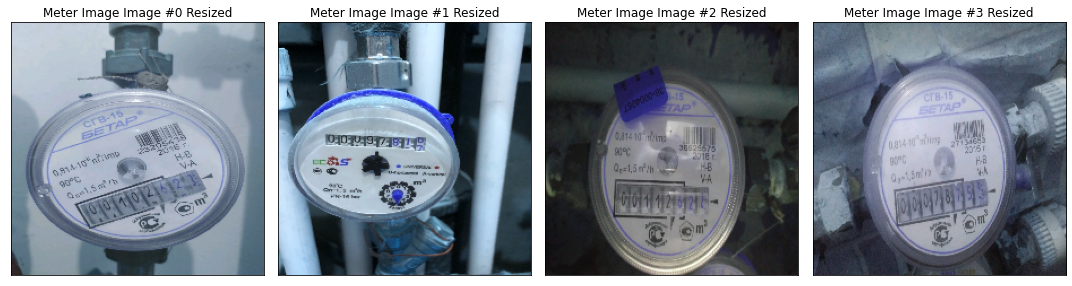

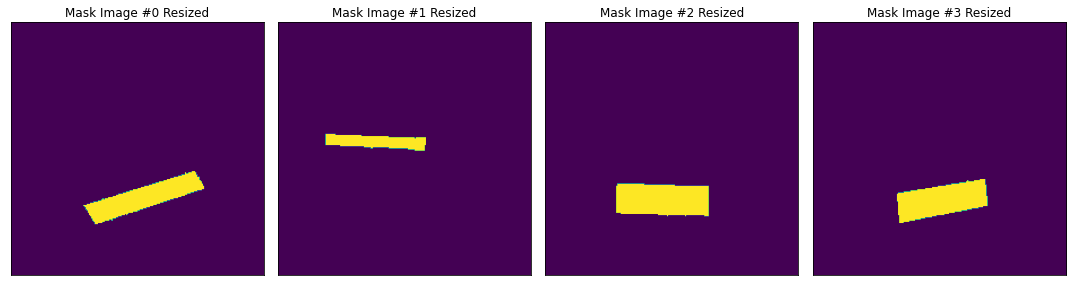

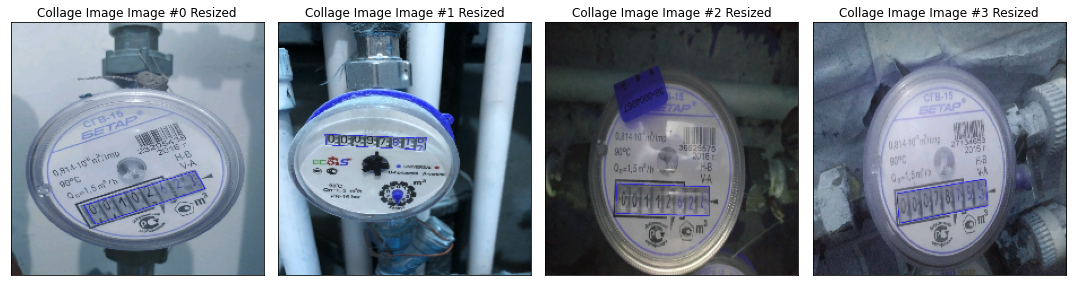

In [17]:
#Print first 4 resized meter, resized mask, and collage images.
plot_seg_imgs(X,'Meter Image')
plot_seg_imgs(y, 'Mask')
plot_seg_imgs('collage', 'Collage Image')

From the above images, we can see that the resized masks are appropriately positioned with regard to the location of the meter reading region for each meter pictured. We can see, however, that unlike the original masks, these are quite pixelated. This is due to our downsizing the mask images to a small fraction of their original size. This should not be problematic for our later UNet model; however, if it does prove problematic, we will adjust the mask sizes accordingly.

In [26]:
#Split data into train and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Segmentation Mask

In [27]:
%%capture

#Download segmentation model from github.
!pip install git+https://github.com/qubvel/segmentation_models
    
import segmentation_models as sm

In [28]:
%%capture

#Download presaved weights
!wget https://github.com/K-Merrick/Water-Meters/blob/main/weights-file.hdf5

In [29]:
import segmentation_models as sm
            
sm.set_framework('tf.keras')
sm.framework()

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

#Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(
    opt,
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

try: 
    #fname = os.path.sep.join([os.getcwd(), "weights-file.hdf5"])
    fname = '../input/weights/weights-file.hdf5'
    print('Weights file loaded.')
except:
    pass

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='new_weights_output.hdf5',
    save_weights_only=False,
    monitor='val_iou_score',
    mode='max',
    save_best_only=True,
    verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)

if os.path.isfile(fname) == True:
    model.load_weights(fname)

# fit model
model.fit(
   x=X_train,
   y=y_train,
   batch_size=16,
   epochs=10, #Only 10, since we've pretrained the model.
   validation_data=(X_test, y_test),
   callbacks=[model_checkpoint_callback, early_stopping]
)

model.save('final_segmentation_model')

# The model weights (that are considered the best) are loaded into the model.
#model.load_weights(fname)

85532672/85521592 [==============================] - 4s 0us/step
Weights file loaded.


2021-12-07 13:22:51.533158: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 599101440 exceeds 10% of free system memory.
2021-12-07 13:22:52.177999: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 199700480 exceeds 10% of free system memory.
2021-12-07 13:22:52.418280: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 599101440 exceeds 10% of free system memory.
2021-12-07 13:22:52.850578: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 199700480 exceeds 10% of free system memory.


Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 0.0320 - iou_score: 0.9744

2021-12-07 13:23:06.318693: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 149925888 exceeds 10% of free system memory.


63/63 [==============================] - 15s 153ms/step - loss: 0.0320 - iou_score: 0.9744 - val_loss: 0.0319 - val_iou_score: 0.9750

Epoch 00001: val_iou_score improved from -inf to 0.97501, saving model to new_weights_output.hdf5
Epoch 2/10
63/63 [==============================] - 8s 121ms/step - loss: 0.0225 - iou_score: 0.9816 - val_loss: 0.0304 - val_iou_score: 0.9761

Epoch 00002: val_iou_score improved from 0.97501 to 0.97611, saving model to new_weights_output.hdf5
Epoch 3/10
63/63 [==============================] - 8s 123ms/step - loss: 0.0193 - iou_score: 0.9838 - val_loss: 0.0315 - val_iou_score: 0.9752

Epoch 00003: val_iou_score did not improve from 0.97611
Epoch 4/10
63/63 [==============================] - 8s 122ms/step - loss: 0.0164 - iou_score: 0.9866 - val_loss: 0.0305 - val_iou_score: 0.9759

Epoch 00004: val_iou_score did not improve from 0.97611
Epoch 5/10
63/63 [==============================] - 8s 124ms/step - loss: 0.0146 - iou_score: 0.9878 - val_loss: 0.0308

2021-12-07 13:24:26.873467: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


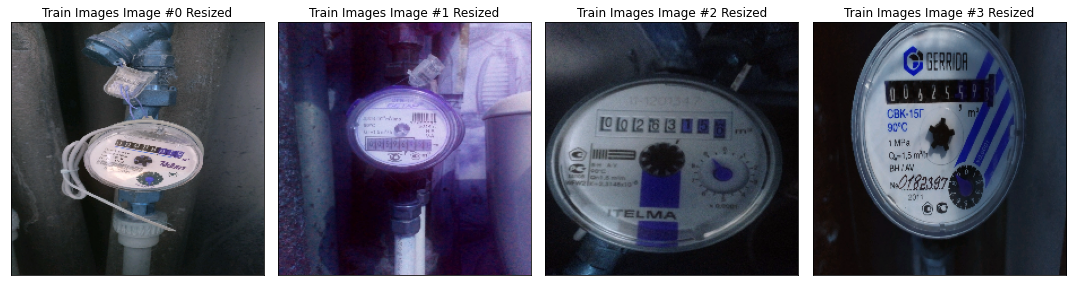

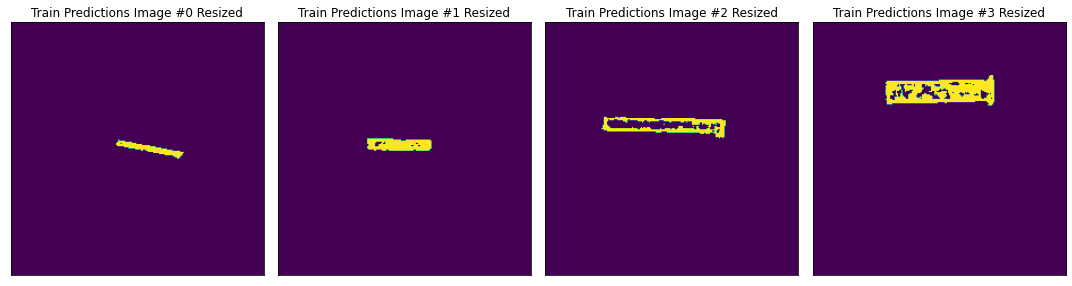

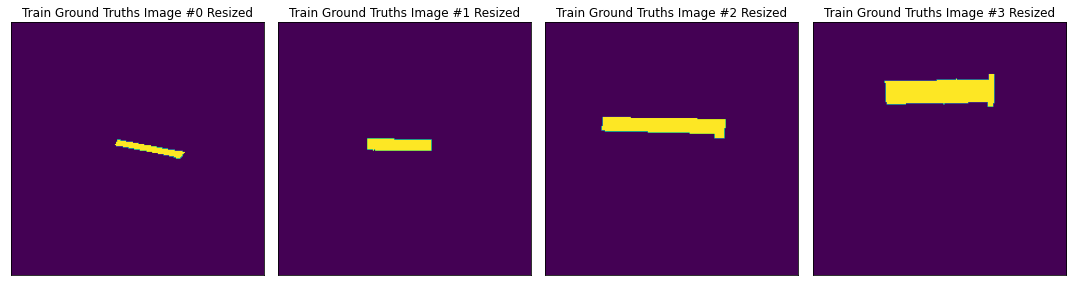

In [30]:
# Examine predictions for training images.
plot_seg_imgs(X_train, 'Train Images')
plot_seg_imgs(model.predict(X_train), 'Train Predictions')
plot_seg_imgs(y_train, 'Train Ground Truths')

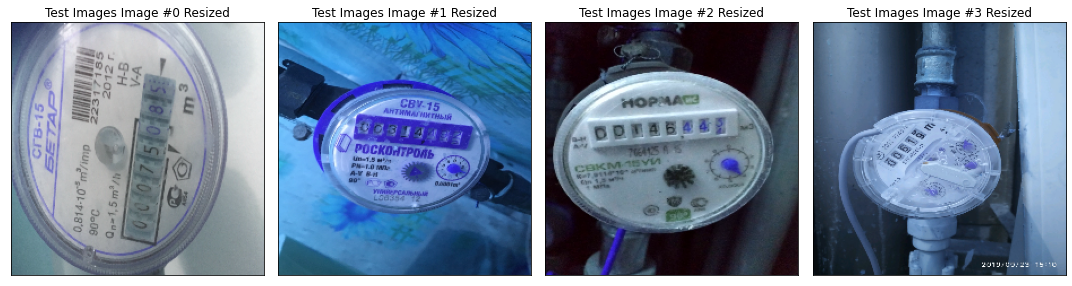

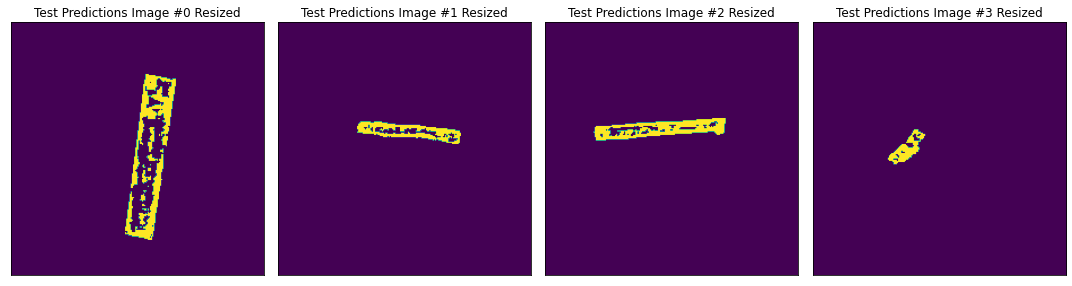

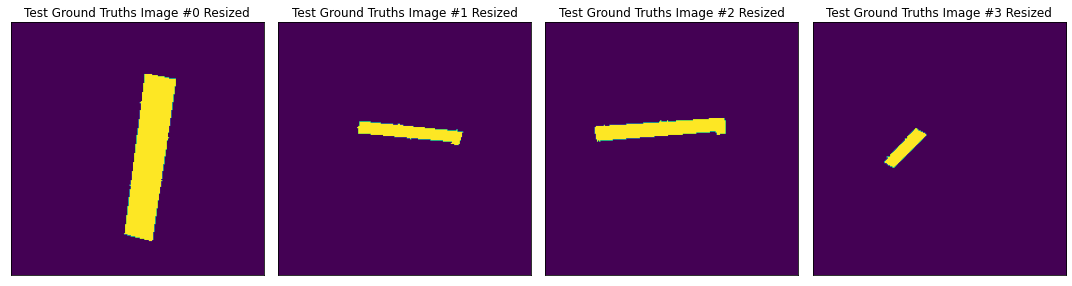

In [31]:
#Examine predictions for testing images.
plot_seg_imgs(X_test, 'Test Images')
plot_seg_imgs(model.predict(X_test), 'Test Predictions')
plot_seg_imgs(y_test, 'Test Ground Truths')